In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, random
path = '/home/nonsodono/CV_Projects/Emotion Recognition Classifier'
os.chdir(path)  

In [3]:
#hide
!pip3 install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

/home/nonsodono/CV_Projects/cv_env/lib/python3.9/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [4]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
    )

In [5]:
dls = faces.dataloaders(path)

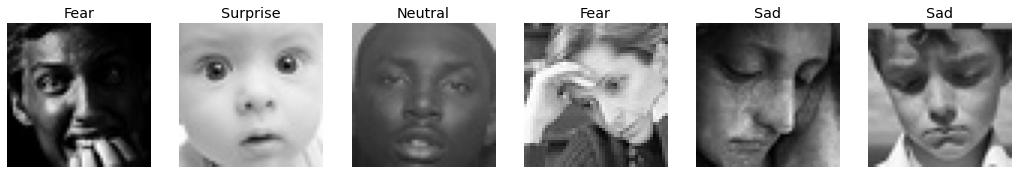

In [6]:
dls.train.show_batch(max_n=6, nrows=1)

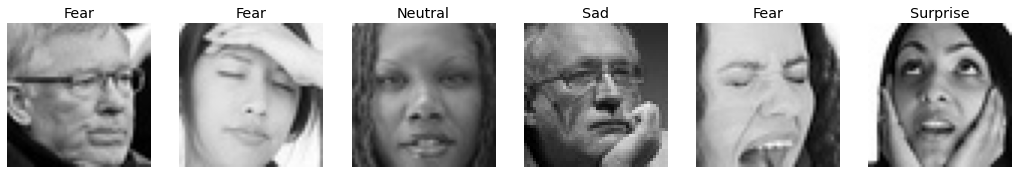

In [7]:
dls.valid.show_batch(max_n=6, nrows=1)

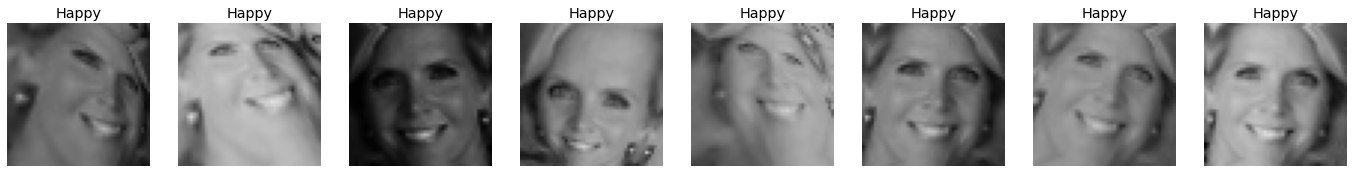

In [8]:
faces = faces.new(item_tfms=Resize(48), batch_tfms=aug_transforms(mult=2))
dls = faces.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

In [22]:
model = cnn_learner(dls, vgg19_bn, metrics=accuracy)
model.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.053985,1.740443,0.331053,00:35


epoch,train_loss,valid_loss,accuracy,time
0,1.652927,1.461220,0.453509,00:50
1,1.438576,1.262862,0.520175,00:50
2,1.295874,1.153462,0.564561,00:51
3,1.199318,1.115170,0.578947,00:51
4,1.156716,1.087631,0.604386,00:51
5,1.116140,1.022066,0.623684,00:51
6,1.087209,1.044682,0.615439,00:51
7,1.037503,1.003035,0.632105,00:52
8,0.965942,0.964409,0.654035,00:51
9,0.955346,0.951981,0.659298,00:50


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), str(path/cat).split('.')[0] + "_fixed.jpg")

In [ ]:
model.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
model_inf = load_learner(path/'export.pkl')

In [ ]:
model_inf.dls.vocab

In [ ]:
model.show_results()

In [ ]:
model.predict('/home/nonsodono/Documents/test1.jpg')

In [ ]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = model_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your face!'), 
      btn_upload, btn_run, out_pl, lbl_pred])